In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import gc
import time


class EfficientGeluFunction(Function):
    """
    Custom implementation of the GELU activation function with memory optimizations.
    GELU(x) = x * Φ(x) where Φ(x) is the Gaussian CDF.
    
    This implementation uses a more memory-efficient approximation:
    GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x^3)))
    """

    @staticmethod
    def forward(ctx, input):
        """
        Forward pass computation.
        
        Args:
            ctx: Context object to store variables for backward pass
            input: Input tensor
            
        Returns:
            Output tensor
        """
        # Compute GELU using approximation
        sqrt_2_pi = 0.7978845608028654  # sqrt(2/pi)
        # Save intermediate tensors for backward
        tanh_input = torch.tanh(sqrt_2_pi * (input + 0.044715 * torch.pow(input, 3)))
        ctx.save_for_backward(input, tanh_input)
        
        # Compute output
        output = 0.5 * input * (1 + tanh_input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass computation.
        
        Args:
            ctx: Context with saved variables from forward pass
            grad_output: Gradient from upstream
            
        Returns:
            Gradient for input
        """
        # Retrieve saved variables
        input, tanh_input = ctx.saved_tensors
        
        # Constants
        sqrt_2_pi = 0.7978845608028654
        
        # To save memory, compute parts using no_grad when possible
        with torch.no_grad():
            # Compute derivative components
            cosh_squared = 1 - tanh_input * tanh_input  # derivative of tanh
            inner_deriv = sqrt_2_pi * (1 + 3 * 0.044715 * input * input)
            
        # Compute gradient
        grad_input = 0.5 * (1 + tanh_input) + 0.5 * input * cosh_squared * inner_deriv
        
        # Apply chain rule with incoming gradient
        return grad_output * grad_input


PyTorch Memory-Efficient Autograd Implementation

1. Testing Gradient Verification for Custom Activation
Gradient check passed: True

2. Comparing Activation Functions
Testing on tensor of size (50, 500) on cuda

Standard GELU:

Efficient GELU (with gradient tracking):

Efficient GELU (without gradient tracking):

Results Summary:
Metric                    Standard GELU        Efficient GELU       Efficient (no_grad) 
-------------------------------------------------------------------------------------
Allocated Before                       0.25 MB                0.27 MB                0.27 MB  
Allocated After                        0.27 MB                0.38 MB                0.29 MB  
Cached Before                          2.00 MB                2.00 MB                2.00 MB  
Cached After                           2.00 MB                2.00 MB                2.00 MB  
Execution Time                         2.29 ms               13.88 ms                0.27 ms  

Efficient GELU v

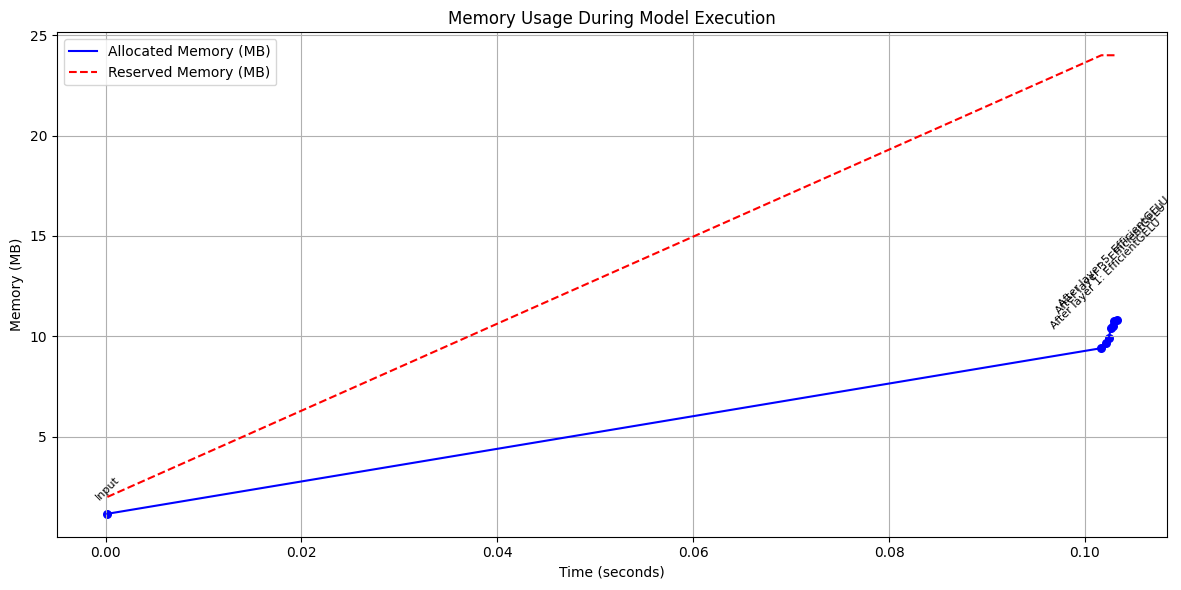


Function demo_memory_tracking_model executed in 325.37 ms

Memory Profiling Summary:
----------------------------------------------------------------------------------------------------
Label                          Time (s)   Allocated (MB)  Reserved (MB)   Δ Allocated    
----------------------------------------------------------------------------------------------------
Before demo_memory_tracking_model 0.000      0.00            0.00            -              
After demo_memory_tracking_model 0.326      18.47           26.00           +18.47         
After cleanup                  0.397      18.47           24.00           +0.00          
----------------------------------------------------------------------------------------------------
Peak allocated memory: 18.47 MB
Peak reserved memory: 26.00 MB

4. Comparing no_grad vs detach

Memory Profiling Summary:
----------------------------------------------------------------------------------------------------
Label                  

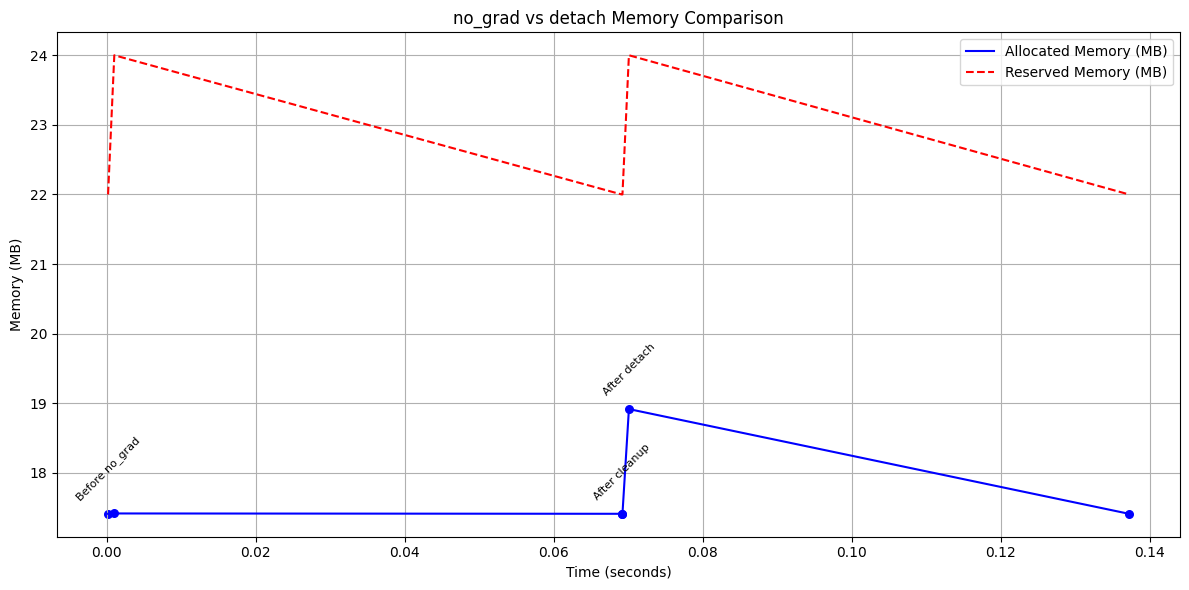


5. Comparing Standard and Optimized Models
Training standard model:
Epoch 1, Loss: 1.0119, Memory: 18.24MB allocated, 24.00MB cached
Epoch 2, Loss: 0.9729, Memory: 18.24MB allocated, 24.00MB cached
Epoch 3, Loss: 0.9397, Memory: 18.24MB allocated, 24.00MB cached

Training optimized model:
Epoch 1, Loss: 1.0138, Memory: 18.01MB allocated, 24.00MB cached
Epoch 2, Loss: 0.9715, Memory: 18.01MB allocated, 24.00MB cached
Epoch 3, Loss: 0.9371, Memory: 18.01MB allocated, 24.00MB cached


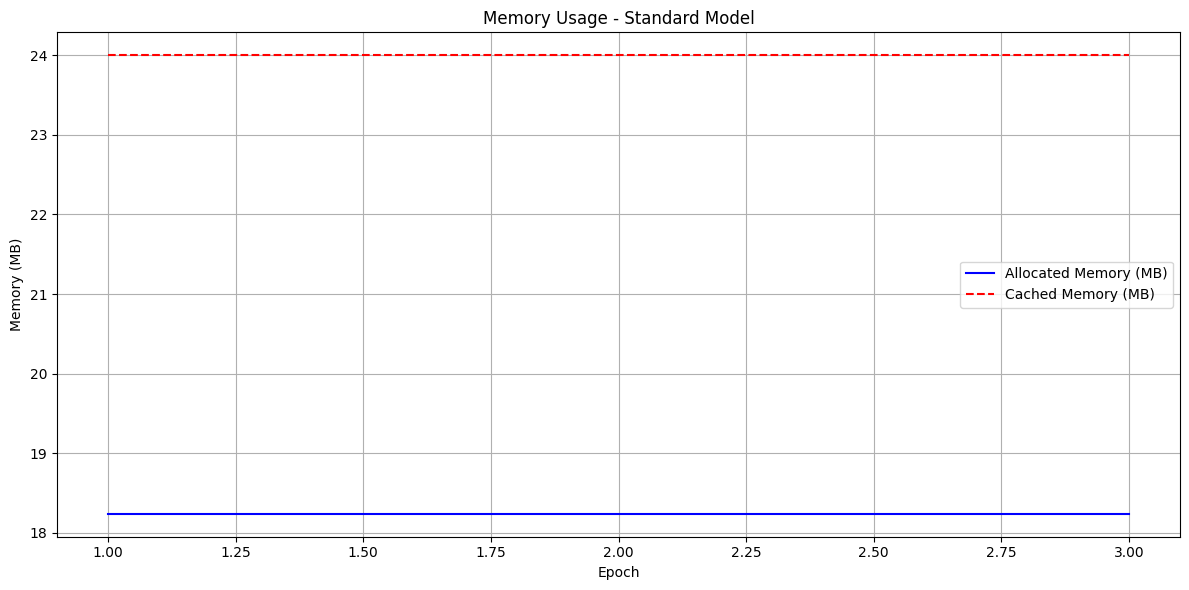

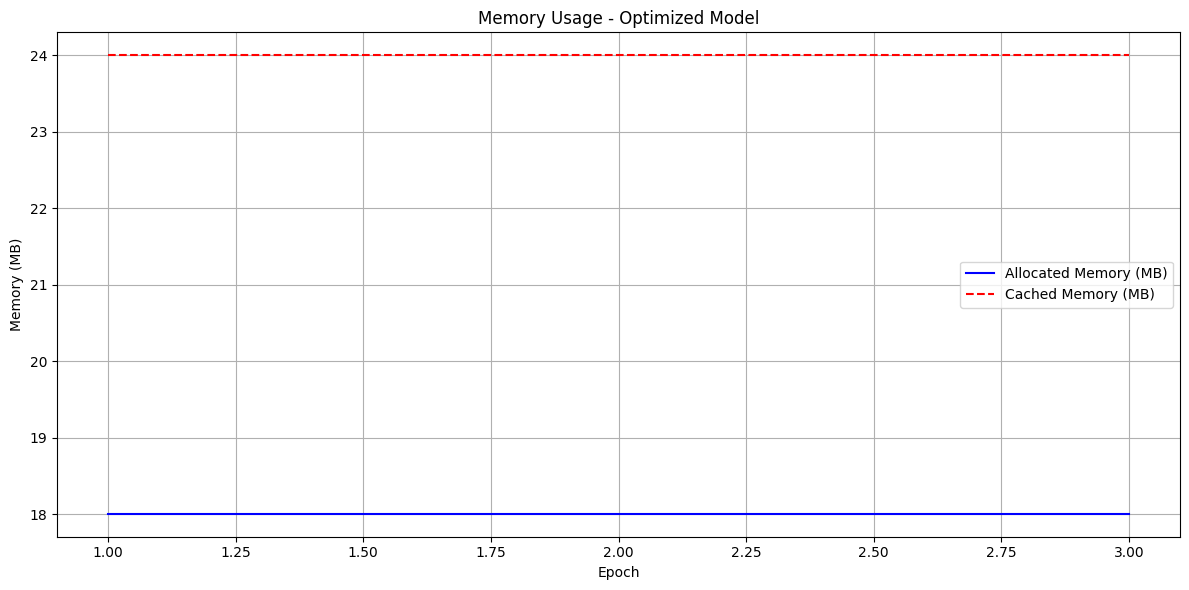

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Function
import gc
import time
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from functools import wraps


# ============= Part 1: Custom Efficient Activation Function =============

class EfficientGeluFunction(Function):
    """
    Custom implementation of the GELU activation function with memory optimizations.
    GELU(x) = x * Φ(x) where Φ(x) is the Gaussian CDF.
    
    This implementation uses a more memory-efficient approximation:
    GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x^3)))
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        Forward pass computation.
        
        Args:
            ctx: Context object to store variables for backward pass
            input: Input tensor
            
        Returns:
            Output tensor
        """
        # Compute GELU using approximation
        sqrt_2_pi = 0.7978845608028654  # sqrt(2/pi)
        # Save intermediate tensors for backward
        tanh_input = torch.tanh(sqrt_2_pi * (input + 0.044715 * torch.pow(input, 3)))
        ctx.save_for_backward(input, tanh_input)
        
        # Compute output
        output = 0.5 * input * (1 + tanh_input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass computation.
        
        Args:
            ctx: Context with saved variables from forward pass
            grad_output: Gradient from upstream
            
        Returns:
            Gradient for input
        """
        # Retrieve saved variables
        input, tanh_input = ctx.saved_tensors
        
        # Constants
        sqrt_2_pi = 0.7978845608028654
        
        # To save memory, compute parts using no_grad when possible
        with torch.no_grad():
            # Compute derivative components
            cosh_squared = 1 - tanh_input * tanh_input  # derivative of tanh
            inner_deriv = sqrt_2_pi * (1 + 3 * 0.044715 * input * input)
            
        # Compute gradient
        grad_input = 0.5 * (1 + tanh_input) + 0.5 * input * cosh_squared * inner_deriv
        
        # Apply chain rule with incoming gradient
        return grad_output * grad_input


class EfficientGELU(nn.Module):
    """
    Module wrapper for the EfficientGeluFunction
    """
    def __init__(self):
        super(EfficientGELU, self).__init__()
    
    def forward(self, x):
        return EfficientGeluFunction.apply(x)


def track_memory_usage(function, input_tensor, trials=5):
    """
    Track memory usage before and after function execution.
    
    Args:
        function: Function to execute
        input_tensor: Input tensor
        trials: Number of trials to run
        
    Returns:
        Dictionary with memory statistics
    """
    results = {
        "allocated_before": [],
        "allocated_after": [],
        "cached_before": [],
        "cached_after": [],
        "execution_time": []
    }
    
    for _ in range(trials):
        # Clear cache and run garbage collection
        torch.cuda.empty_cache()
        gc.collect()
        
        # Record memory before
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            allocated_before = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
            cached_before = torch.cuda.memory_reserved() / (1024 ** 2)      # MB
        else:
            allocated_before = 0
            cached_before = 0
        
        # Run function
        start_time = time.time()
        output = function(input_tensor)
        
        # Ensure computation is complete
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        execution_time = time.time() - start_time
        
        # Record memory after
        if torch.cuda.is_available():
            allocated_after = torch.cuda.memory_allocated() / (1024 ** 2)   # MB
            cached_after = torch.cuda.memory_reserved() / (1024 ** 2)       # MB
        else:
            allocated_after = 0
            cached_after = 0
        
        # Store results
        results["allocated_before"].append(allocated_before)
        results["allocated_after"].append(allocated_after)
        results["cached_before"].append(cached_before)
        results["cached_after"].append(cached_after)
        results["execution_time"].append(execution_time)
        
        # Run backward pass in evaluation
        if output.requires_grad and input_tensor.requires_grad:
            out_sum = output.sum()
            out_sum.backward()
    
    # Calculate averages
    for key in results:
        results[key] = sum(results[key]) / len(results[key])
    
    return results


# ============= Part 2: Memory-Optimized Model =============

class MemoryOptimizedModel(nn.Module):
    """
    A neural network model that implements memory optimization techniques
    """
    def __init__(self, input_size, hidden_size, output_size, use_efficient_activation=True):
        super(MemoryOptimizedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        
        # Choose activation function
        self.activation = EfficientGELU() if use_efficient_activation else nn.GELU()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.activation(x)
        
        # Manual memory optimization
        # Detach intermediate activations when not needed for backward pass
        if not torch.is_grad_enabled():
            x = x.detach()  # Breaks computational graph when not needed
        
        # Layer 2
        x = self.fc2(x)
        x = self.activation(x)
        
        # Layer 3
        x = self.fc3(x)
        return x
    
    def optimize_memory_during_inference(self, x):
        """
        Memory-optimized inference method
        """
        with torch.no_grad():
            # Process in chunks if input is large
            if x.size(0) > 1000:
                chunk_size = 1000
                outputs = []
                
                for i in range(0, x.size(0), chunk_size):
                    # Process a chunk
                    chunk = x[i:i+chunk_size]
                    output_chunk = self.forward(chunk)
                    outputs.append(output_chunk)
                    
                    # Explicitly clean up
                    del chunk, output_chunk
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    gc.collect()
                
                return torch.cat(outputs, dim=0)
            else:
                return self.forward(x)


def train_with_memory_tracking(model, X, y, epochs=5, batch_size=64, learning_rate=0.001):
    """
    Train a model with memory tracking
    """
    device = next(model.parameters()).device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    n_samples = X.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    memory_stats = {
        "epoch": [],
        "allocated_memory": [],
        "cached_memory": []
    }
    
    for epoch in range(epochs):
        # Track memory at epoch start
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.synchronize()
            start_allocated = torch.cuda.memory_allocated() / (1024 ** 2)
            start_cached = torch.cuda.memory_reserved() / (1024 ** 2)
        else:
            start_allocated = start_cached = 0
        
        total_loss = 0
        
        # Shuffle data
        indices = torch.randperm(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            # Get batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update total loss
            total_loss += loss.item()
            
            # Memory cleanup after batch
            del X_batch, y_batch, y_pred, loss
            if (i + 1) % 10 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()
        
        # Track memory at epoch end
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            end_allocated = torch.cuda.memory_allocated() / (1024 ** 2)
            end_cached = torch.cuda.memory_reserved() / (1024 ** 2)
        else:
            end_allocated = end_cached = 0
            
        # Store memory stats
        memory_stats["epoch"].append(epoch + 1)
        memory_stats["allocated_memory"].append(end_allocated)
        memory_stats["cached_memory"].append(end_cached)
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/n_batches:.4f}, "
              f"Memory: {end_allocated:.2f}MB allocated, {end_cached:.2f}MB cached")
    
    return memory_stats


def visualize_memory_usage(memory_stats, title="Memory Usage During Training"):
    """
    Visualize memory usage during training
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(memory_stats["epoch"], memory_stats["allocated_memory"], 'b-', label="Allocated Memory (MB)")
    plt.plot(memory_stats["epoch"], memory_stats["cached_memory"], 'r--', label="Cached Memory (MB)")
    
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Memory (MB)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# ============= Part 3: Memory Profiling Tools =============

class MemoryProfiler:
    """
    A utility class for profiling memory usage in PyTorch.
    """
    def __init__(self, enabled=True):
        self.enabled = enabled and torch.cuda.is_available()
        self.records = []
        self.start_time = None
    
    def start(self):
        """Start the profiler"""
        if self.enabled:
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.synchronize()
            self.start_time = time.time()
            self.records = []
    
    def record(self, label):
        """Record current memory usage with a label"""
        if self.enabled:
            torch.cuda.synchronize()
            allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
            reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB
            current_time = time.time() - self.start_time
            
            self.records.append({
                "label": label,
                "time": current_time,
                "allocated": allocated,
                "reserved": reserved
            })
    
    def summary(self):
        """Print a summary of recorded memory usage"""
        if not self.enabled or not self.records:
            print("No memory profiling data available")
            return
        
        df = pd.DataFrame(self.records)
        
        print("\nMemory Profiling Summary:")
        print("-" * 100)
        print(f"{'Label':<30} {'Time (s)':<10} {'Allocated (MB)':<15} {'Reserved (MB)':<15} {'Δ Allocated':<15}")
        print("-" * 100)
        
        prev_allocated = 0
        for idx, row in df.iterrows():
            delta = row['allocated'] - prev_allocated if idx > 0 else 0
            delta_str = f"{delta:+.2f}" if idx > 0 else "-"
            print(f"{row['label']:<30} {row['time']:<10.3f} {row['allocated']:<15.2f} {row['reserved']:<15.2f} {delta_str:<15}")
            prev_allocated = row['allocated']
        
        print("-" * 100)
        print(f"Peak allocated memory: {df['allocated'].max():.2f} MB")
        print(f"Peak reserved memory: {df['reserved'].max():.2f} MB")
    
    def plot(self, title="Memory Usage Over Time", save_path=None):
        """Plot memory usage over time"""
        if not self.enabled or not self.records:
            print("No memory profiling data available to plot")
            return
        
        df = pd.DataFrame(self.records)
        
        plt.figure(figsize=(12, 6))
        
        plt.plot(df['time'], df['allocated'], 'b-', label="Allocated Memory (MB)")
        plt.plot(df['time'], df['reserved'], 'r--', label="Reserved Memory (MB)")
        
        # Add markers at each recording point
        plt.scatter(df['time'], df['allocated'], color='blue', s=30)
        
        # Add labels at interesting points
        for idx, row in df.iterrows():
            if idx % 2 == 0:  # Skip some labels to avoid crowding
                plt.annotate(row['label'], 
                            (row['time'], row['allocated']),
                            textcoords="offset points", 
                            xytext=(0, 10), 
                            ha='center',
                            fontsize=8,
                            rotation=45)
        
        plt.title(title)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Memory (MB)")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        plt.show()


def profile_memory(func):
    """
    Decorator for profiling memory usage of a function
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Initialize profiler
        profiler = MemoryProfiler()
        profiler.start()
        profiler.record(f"Before {func.__name__}")
        
        # Call function
        start_time = time.time()
        result = func(*args, **kwargs)
        execution_time = time.time() - start_time
        
        # Record after function execution
        profiler.record(f"After {func.__name__}")
        
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
        profiler.record(f"After cleanup")
        
        # Show results
        print(f"\nFunction {func.__name__} executed in {execution_time*1000:.2f} ms")
        profiler.summary()
        
        return result
    
    return wrapper


class SequentialWithMemoryTracking(nn.Sequential):
    """
    A version of nn.Sequential that tracks memory usage between layers
    """
    def __init__(self, *args, profile=True):
        super(SequentialWithMemoryTracking, self).__init__(*args)
        self.profiler = MemoryProfiler(enabled=profile)
    
    def forward(self, input):
        self.profiler.start()
        self.profiler.record("Input")
        
        x = input
        for i, module in enumerate(self):
            x = module(x)
            self.profiler.record(f"After layer {i}: {type(module).__name__}")
            
            # Optional memory cleanup between layers during inference
            if not torch.is_grad_enabled() and hasattr(x, 'detach'):
                x = x.detach()
                # Uncomment the following for more aggressive cleanup
                # torch.cuda.empty_cache()
                # gc.collect()
                self.profiler.record(f"After layer {i} cleanup")
        
        return x
    
    def get_memory_profile(self):
        """Return the memory profile data"""
        return self.profiler.records


# ============= Part 4: Demo Functions =============

def compare_activation_functions(input_size=(100, 1000), device="cuda"):
    """
    Compare memory usage and performance of different activation functions
    
    Args:
        input_size: Size of input tensor
        device: Device to run on ("cuda" or "cpu")
        
    Returns:
        Comparison results
    """
    # Set device
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA not available, using CPU instead")
        device = "cpu"
    
    # Create input tensor
    torch.manual_seed(42)
    input_tensor = torch.randn(*input_size, requires_grad=True, device=device)
    
    # Create activation functions
    efficient_gelu = EfficientGELU()
    standard_gelu = nn.GELU()
    
    # Define functions to test
    def run_efficient_gelu(x):
        return efficient_gelu(x)
    
    def run_standard_gelu(x):
        return standard_gelu(x)
    
    def run_efficient_gelu_no_grad(x):
        with torch.no_grad():
            return efficient_gelu(x)
    
    # Test each function
    print(f"Testing on tensor of size {input_size} on {device}")
    
    print("\nStandard GELU:")
    standard_results = track_memory_usage(run_standard_gelu, input_tensor)
    
    print("\nEfficient GELU (with gradient tracking):")
    efficient_results = track_memory_usage(run_efficient_gelu, input_tensor)
    
    print("\nEfficient GELU (without gradient tracking):")
    efficient_no_grad_results = track_memory_usage(run_efficient_gelu_no_grad, input_tensor)
    
    # Print results
    keys = ["allocated_before", "allocated_after", "cached_before", "cached_after", "execution_time"]
    functions = ["Standard GELU", "Efficient GELU", "Efficient GELU (no_grad)"]
    results = [standard_results, efficient_results, efficient_no_grad_results]
    
    print("\nResults Summary:")
    print(f"{'Metric':<25} {'Standard GELU':<20} {'Efficient GELU':<20} {'Efficient (no_grad)':<20}")
    print("-" * 85)
    for key in keys:
        print(f"{key.replace('_', ' ').title():<25}", end="")
        for res in results:
            if "time" in key:
                print(f"{res[key]*1000:>18.2f} ms  ", end="")
            else:
                print(f"{res[key]:>18.2f} MB  ", end="")
        print()
    
    # Memory difference calculation
    for idx, func in enumerate(functions):
        if idx > 0:
            mem_diff = results[idx]["allocated_after"] - results[0]["allocated_after"]
            time_diff = (results[idx]["execution_time"] / results[0]["execution_time"]) * 100 - 100
            print(f"\n{func} vs Standard GELU:")
            print(f"  Memory: {'saved' if mem_diff < 0 else 'increased'} by {abs(mem_diff):.2f} MB")
            print(f"  Time: {'faster' if time_diff < 0 else 'slower'} by {abs(time_diff):.2f}%")
    
    return results


@profile_memory
def demo_memory_tracking_model():
    """
    Demonstrate memory tracking during model execution
    """
    # Create a model that tracks memory usage
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SequentialWithMemoryTracking(
        nn.Linear(100, 256),
        EfficientGELU(),
        nn.Linear(256, 512),
        EfficientGELU(),
        nn.Linear(512, 256),
        EfficientGELU(),
        nn.Linear(256, 10)
    ).to(device)
    
    # Generate input
    x = torch.randn(128, 100, device=device)
    
    # Forward pass with gradient
    y = model(x)
    y.sum().backward()
    
    # Get memory profile
    profile_data = model.get_memory_profile()
    
    # Plot the profile
    profiler = MemoryProfiler()
    profiler.records = profile_data
    profiler.plot(title="Memory Usage During Model Execution")
    
    return model


def compare_no_grad_with_detach():
    """
    Compare memory usage of torch.no_grad() vs manual detach
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.Sequential(
        nn.Linear(100, 256),
        EfficientGELU(),
        nn.Linear(256, 512),
        EfficientGELU(),
        nn.Linear(512, 256),
        EfficientGELU(),
        nn.Linear(256, 10)
    ).to(device)
    
    x = torch.randn(128, 100, device=device)
    
    profiler = MemoryProfiler()
    profiler.start()
    
    # Case 1: Using torch.no_grad()
    profiler.record("Before no_grad")
    with torch.no_grad():
        y_no_grad = model(x)
    profiler.record("After no_grad")
    
    # Clear memory
    del y_no_grad
    torch.cuda.empty_cache()
    gc.collect()
    profiler.record("After cleanup")
    
    # Case 2: Using detach
    profiler.record("Before detach")
    y = model(x)
    y_detach = y.detach()
    profiler.record("After detach")
    
    # Clear memory
    del y, y_detach
    torch.cuda.empty_cache()
    gc.collect()
    profiler.record("After final cleanup")
    
    # Show results
    profiler.summary()
    profiler.plot(title="no_grad vs detach Memory Comparison")


def compare_models():
    """
    Compare memory usage between standard and optimized models
    """
    # Parameters
    input_size = 100
    hidden_size = 256
    output_size = 10
    n_samples = 1000  # Reduced for faster execution
    
    # Generate synthetic data
    torch.manual_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    X = torch.randn(n_samples, input_size, device=device)
    y = torch.randn(n_samples, output_size, device=device)
    
    # Create models
    standard_model = MemoryOptimizedModel(input_size, hidden_size, output_size, 
                                         use_efficient_activation=False).to(device)
    optimized_model = MemoryOptimizedModel(input_size, hidden_size, output_size, 
                                          use_efficient_activation=True).to(device)
    
    # Train models
    print("Training standard model:")
    standard_stats = train_with_memory_tracking(standard_model, X, y, epochs=3)  # Reduced epochs
    
    # Clear memory
    del standard_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()
    
    print("\nTraining optimized model:")
    optimized_stats = train_with_memory_tracking(optimized_model, X, y, epochs=3)  # Reduced epochs
    
    # Visualize results
    visualize_memory_usage(standard_stats, "Memory Usage - Standard Model")
    visualize_memory_usage(optimized_stats, "Memory Usage - Optimized Model")


# ============= Part 5: Main Function =============

def main():
    """
    Main function to demonstrate all features
    """
    print("=" * 50)
    print("PyTorch Memory-Efficient Autograd Implementation")
    print("=" * 50)
    
    print("\n1. Testing Gradient Verification for Custom Activation")
    # Test validation of gradients
    input_tensor = torch.randn(20, 20, dtype=torch.double, requires_grad=True)
    from torch.autograd import gradcheck
    test = gradcheck(EfficientGeluFunction.apply, input_tensor, eps=1e-6, atol=1e-4)
    print(f"Gradient check passed: {test}")
    
    print("\n2. Comparing Activation Functions")
    # Use smaller size for quicker execution
    compare_activation_functions(input_size=(50, 500), device="cuda" if torch.cuda.is_available() else "cpu")
    
    print("\n3. Memory Tracking Demo")
    # Run memory tracking demo
    demo_memory_tracking_model()
    
    print("\n4. Comparing no_grad vs detach")
    # Compare no_grad with detach
    compare_no_grad_with_detach()
    
    print("\n5. Comparing Standard and Optimized Models")
    # Compare models
    compare_models()


if __name__ == "__main__":
    main()

In [4]:
import torch
device = torch.device("cuda")
# 🔹 Custom Activation Function using Autograd
class CustomSwish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input * torch.sigmoid(input)  # Swish Activation: x * sigmoid(x)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        sigmoid_x = torch.sigmoid(input)
        grad_input = grad_output * (sigmoid_x * (1 + input * (1 - sigmoid_x)))
        return grad_input


# 🔹 Track Memory Before
print("Before Activation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# 🔹 Apply Custom Activation Function
x = torch.randn(10000, 10000, device="cuda", requires_grad=True)  # Large tensor
y = CustomSwish.apply(x)
y.sum().backward()

# 🔹 Track Memory After
print("After Activation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# 🔹 Optimize Memory
del x, y
torch.cuda.empty_cache()

# 🔹 Track Memory After Optimization
print("After Optimization:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


Before Activation:
Allocated: 0.00 MB
Reserved: 0.00 MB
After Activation:
Allocated: 1146.00 MB
Reserved: 1912.00 MB
After Optimization:
Allocated: 0.00 MB
Reserved: 0.00 MB


In [ ]:
import torch
device = torch.device("cuda")
# 🔹 Custom Activation Function using Autograd
class CustomSwish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return x * 0.5 * (1 + torch.erf(x / torch.sqrt(2)))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        sigmoid_x = torch.sigmoid(input)
        grad_input = grad_output * (sigmoid_x * (1 + input * (1 - sigmoid_x)))
        return grad_input


# 🔹 Track Memory Before
print("Before Activation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# 🔹 Apply Custom Activation Function
x = torch.randn(10000, 10000, device="cuda", requires_grad=True)  # Large tensor
y = CustomSwish.apply(x)
y.sum().backward()

# 🔹 Track Memory After
print("After Activation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# 🔹 Optimize Memory
del x, y
torch.cuda.empty_cache()

# 🔹 Track Memory After Optimization
print("After Optimization:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


Before Activation:
Allocated: 0.00 MB
Reserved: 0.00 MB
After Activation:
Allocated: 1146.00 MB
Reserved: 1912.00 MB
After Optimization:
Allocated: 0.00 MB
Reserved: 0.00 MB
